# An Examination of AI and Machine Learning Techniques for Stock Market Predictions
### Can stock price movement be predicted using historic stock market data?

<center>
    <img src = images/stock-banner.jpg width = 100%/>
</center>


## Executive Summary
Being able to predict stock price movement can help inform investment decisions. If a stock is predicted to go up within a particular timeframe, it can be bought, held for that period, and then sold for a gain.

The goal of this project is to determine whether a machine learning model can be developed to predict the days on which a stock is expected to rise—using historical data—with better results than buying on random days. Ideally, if a trader buys only on days indicated by the model, they would expect a net gain over losses. In this scenario, only when the model predicts a daily price increase, trades are made each day after the market opens and then sold at closing.

The trader would like to maximize the number of Desired True Positives which represent days that the model predicted and in fact the stock went up.  

The following should be minimized: "Costly Mistakes" because those are days where the model incorrectly indicated a purchase should be made but money was lost as the price went down. And (2) "Missed Opportunities" are days that the stock value increased but the model incorrectly did not indicate a purchase should be made.

<center>
<img src = images/IdealConfusionMatrix.png width=45% />
</center>


### Findings

_Best Evaluated Model: Support Vector Machine_

Of the classification type prediction models evaluated, the SVM/SVC model performed the best at predicting price increases. It achieved the highest F1 score of 0.6685, which takes into account missed opportunities, and a precision score of 0.62. The ratio of money-making predictions (TP: 121) to money-losing predictions (FP: 73) was 1.66 to 1.

<center>
<img src = images/out/confusion_matrix_for_svm.png width=45% />
</center>


_Important Inputs for Prediction_

An inspection revealed the most important historical and calculated features (inputs) as represented by one of the models:

1. Two-day horizon ratio (opening price divided by the average closing price for the past 2 days)
2. Yesterday's volatility index (VIX)
3. 2-day price change
4. 1-month price change
5. Number of days since the last dividend
6. Yesterday's volume

_Inputs with High Correlation With Outcomes_

As part of exploratory data analysis (EDA), it was discovered that the highest correlations with price changes were associated with the two-day horizon ratio (opening price divided by the average closing price of the previous two days) as well as the one-day and two-day price changes. This finding suggests some market momentum, where price increases on previous days can help predict continued upward movement.
<center>
<img src = images/CorrelationHeatmapSummary.png width=100% />
</center>


_Standard Distribution of Price Changes_


Changes in the daily price (delta) appear to form an approximately bell-shaped curve. This indicates that small corrections in the stock value occur more frequently, whereas large price changes—either positive or negative—are relatively rare. Future research could leverage this distribution to estimate the potential magnitude of price changes offering additional insights for traders.
<center>
<img src = images/out/histogram_daily_close_change.png width=45% />
</center>

### Results and Conclusion

The highest performing model tested was a Support Vector Machine. For the stock examined in this project (Apple Computers - AAPL), the model resulted in a 1.66 to 1 ratio of money making trade vs money losing trades. This indicates that the model could beat out purchasing stocks on a random selection of days, which for this stock has a 1:13 to 1 ratio. 


### Next Steps and Recommendations 

While this preliminary investigation provides a useful model, additional enhancements can be made. 

* Continue to tune the SVM and Decision Tree models. For example, exploring different the C value and kernels for SVM.
* Continued exploration in feature selection using PCA to see if better results can be achieved with fewer features.
* Additional performance metric features in the form of derived attributes.
* Investigate additional models such as neural networks.
* Attempting to understand the magnitude of price changes by using regression models.
* Using additional input data such as news sentiment analysis and other market indices.
* Analyze the stocks of other companies other than Apple Computer

## Methodology: CRISP-DM Framework
For this application, an industry standard model called CRISP-DM is used.  This process provides a framework for working through a data problem.  



<center>
    <img src = images/crisp.png width = 50%/>
</center>

<center>
    <img src = images/CRISP-DM-Methodology.png width = 80%/>
</center>




## Data Understanding & Data Preparation

Historical Apple Computer (AAPL) stock price data was gathered from Yahoo! Finance. This including historic prices, volume, and dividends. A market indicator, Volatility Index (VIX) was also retrieved. 


To understand data  and quality of the Yahoo! Finance data, the following steps will be performed:
1. Collect Initial Data - Load Data
2. Describe Data & Data Quality - Understand Fields
3. Explore Data - Understand data values, statistic relevance

This information will be used to guide data understanding and modeling. 

### 1. Collect Initial Data - Load Data
The source of the data was Yahoo Finance: 

https://finance.yahoo.com/

A five year time window between March 16, 2020 to March 14, 2025 was selected to get sufficient data necessary for training of approximately 1000 daily records. A total of 1257 records were collected to ensure incomplete historic information at the beginning of the time series data could be discarded.

In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
import math as math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import sklearn.metrics as metrics
import time

In [2]:
# Read Data

symbol = 'AAPL'
price_df = pd.read_csv('data/' + symbol + '-price.csv')
dividend_df = pd.read_csv('data/' + symbol + '-dividend.csv')
vix_df = pd.read_csv('data/^VIX.csv')

In [3]:
#Read Prototyped Data in Excel
#symbol = 'AAPL'
#nom_data = pd.read_csv('draft/AAPL-csv.csv').dropna()

#nom_data

### 2. Describe Data & Data Quality - Understand Fields

For this exercise, a single stock, Apple Computer (AAPL) was examined. The dataset from Yahoo! Finance provides the following fields:

* Date - Date of the values 
* Open - Opening price or index value (Note: This is not the closing price as the initial sale is negotiated after closing due to after hours trading)
* High - High price or index value of the day
* Low - Low price or index value of the date
* Close - Price or index value at closing
* Adj Close - Price taking into account dividends and other factors (not used in this exercise)
* Volume - Number of trades on this day

* Dividend Date - Date a cash dividend was issued
* Dividend Amount - Amount per share 


The quality of the data from Yahoo! Finance is excellent. Data was provided for all days the market was open (weekdays excluding trading holidays).

In [4]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1257 non-null   object 
 1   Open       1257 non-null   float64
 2   High       1257 non-null   float64
 3   Low        1257 non-null   float64
 4   Close      1257 non-null   float64
 5   Adj Close  1257 non-null   float64
 6   Volume     1257 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [5]:
price_df.head(7)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-03-16,60.487499,64.769997,60.000000,60.552502,58.779289,322423600
1,2020-03-17,61.877499,64.402496,59.599998,63.215000,61.363823,324056000
2,2020-03-18,59.942501,62.500000,59.279999,61.667500,59.861637,300233600
3,2020-03-19,61.847500,63.209999,60.652500,61.195000,59.402977,271857200
4,2020-03-20,61.794998,62.957500,57.000000,57.310001,55.631741,401693200
5,2020-03-23,57.020000,57.125000,53.152500,56.092499,54.449898,336752800
6,2020-03-24,59.090000,61.922501,58.575001,61.720001,59.912598,287531200


In [6]:
price_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03
mean,160.196888,161.961691,158.537315,160.334308,158.489126,8.565798e+07
std,41.203216,41.431059,40.987410,41.248418,41.899680,4.778116e+07
min,57.020000,57.125000,53.152500,56.092499,54.449898,2.025219e+07
25%,133.800003,135.020004,131.929993,133.580002,130.838745,5.376350e+07
50%,158.740005,160.449997,155.800003,157.830002,155.828522,7.353180e+07
75%,183.449997,184.960007,181.919998,183.789993,182.436859,1.012356e+08
max,258.190002,260.100006,257.630005,259.019989,258.735504,4.016932e+08


In [7]:
dividend_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       20 non-null     object 
 1   Dividends  20 non-null     float64
dtypes: float64(1), object(1)
memory usage: 452.0+ bytes


In [8]:
dividend_df.describe()

,Dividends
count,20.000000
mean,0.229000
std,0.016026
min,0.205000
25%,0.220000
50%,0.230000
75%,0.240000
max,0.250000


In [9]:
#Count number of rows with NAs in any column
na_count = price_df.isna().any(axis=1).sum()
print(f"Number of rows with NA in any column: {na_count}")

Number of rows with NA in any column: 0


### 3. Explore Data - Perform Exploratory Data Analysis (EDA)
Perform a series of plots to understand the data and intuitively see if there are any correlations to the target price feature. Identify Data Anomalies in the dataset. 
For this use case, I believe that outliers are important as they represent major events which greatly affect the outcome and should be captured and included in the dataset.  Specific analysis below.


#### Price and Volume Data

The open and close prices remain close on most days. Since the scenario is to produce a tool for traders to action at the start of their day, the market open price can be used as input to the model. 

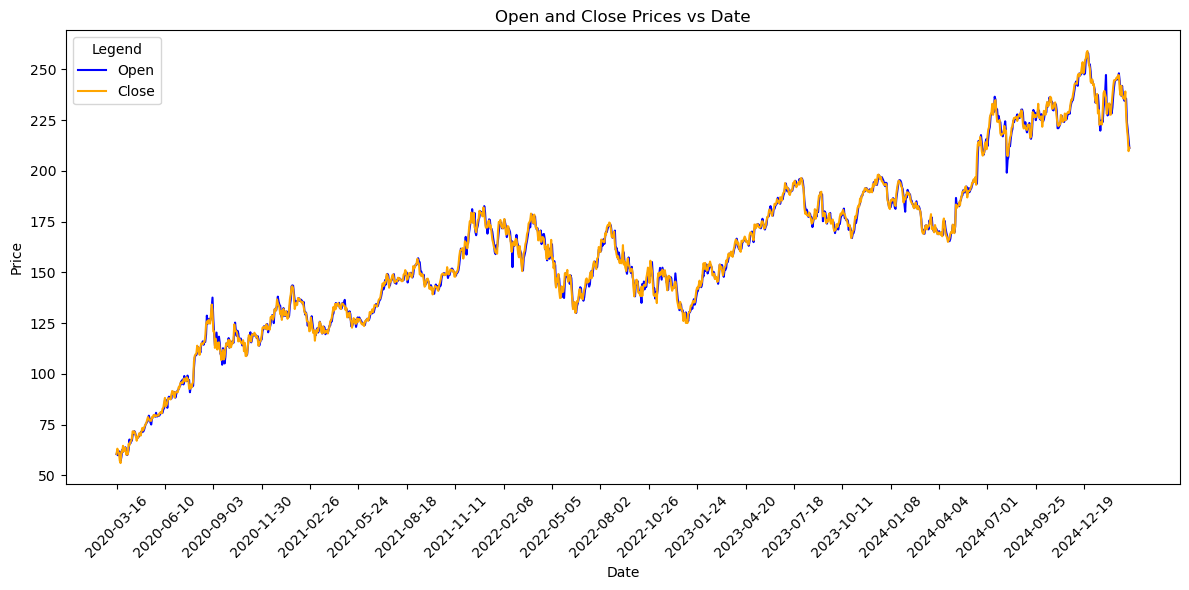

In [10]:
# Plot Open and Close on the same graph
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Open prices
sns.lineplot(data=price_df, x="Date", y="Open", ax=ax, label="Open", color="blue")

# Plot Close prices
sns.lineplot(data=price_df, x="Date", y="Close", ax=ax, label="Close", color="orange")

# Customize the plot
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("Open and Close Prices vs Date")
ax.legend(title="Legend")
ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
ax.set_xticks(ax.get_xticks()[::60])  # Set x-axis ticks every 60 entries

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#### Statistical Analysis of Close Prices

It does not appear that closing prices of this stock follows a normal distribution. This is likely due to several factors including the fact the stock factors are related to company performance and external factors that are also not gaussian in nature. The standard deviation was 41.24. Since the stock is modeled generally increasing in price holding steady in the middle, there are not many outliers in the data as can be seen in the box plot.

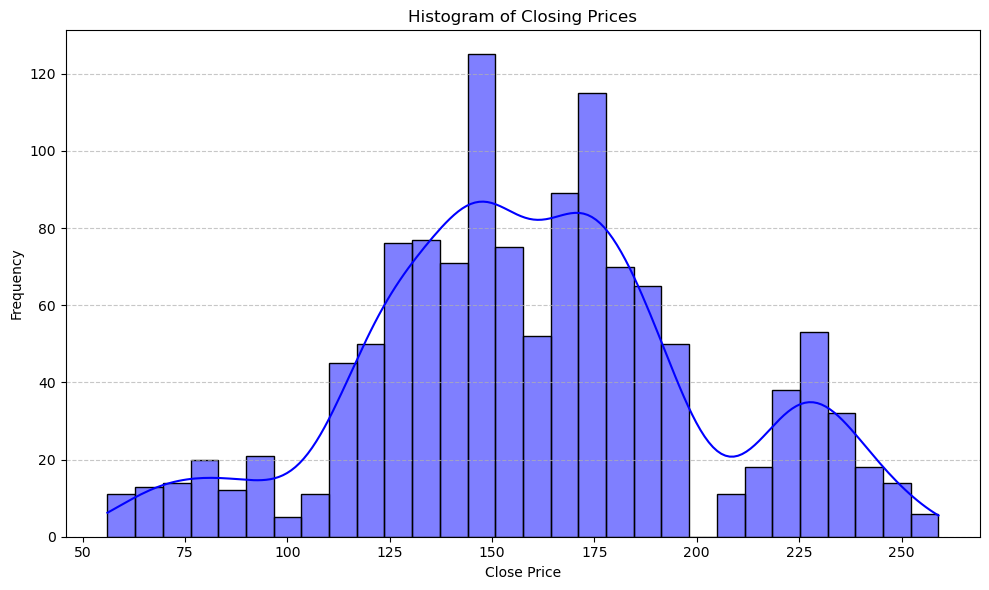

,Close
count,1257.000000
mean,160.334308
std,41.248418
min,56.092499
25%,133.580002
50%,157.830002
75%,183.789993
max,259.019989


In [11]:
# Create a histogram of the Close prices

plt.figure(figsize=(10, 6))
sns.histplot(price_df['Close'], bins=30, kde=True, color='blue')

# Customize the plot
plt.title('Histogram of Closing Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig('images/out/histogram_of_closing_prices.png', dpi=300, bbox_inches='tight')
plt.show()
price_df[['Close']].describe()

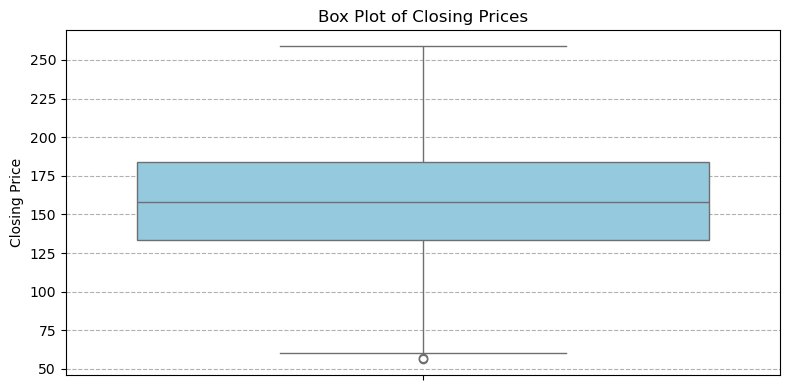

In [12]:
# Create a box plot for the closing price
plt.figure(figsize=(8, 4))
sns.boxplot(data=price_df, y='Close', color='skyblue')

# Customize the plot
plt.title('Box Plot of Closing Prices')
plt.ylabel('Closing Price')
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

#### Statistical Analysis of Volume

While trading volume follows a roughly normal distribution, it is very skewed towards large trades. Numerical analysis confirms this skew with a coefficient of over two. The box plot showing outliers also show significant number of trades that were outliers on the high side. This could be due to a high number of institutional investors that react upon certain market changes with big trades.

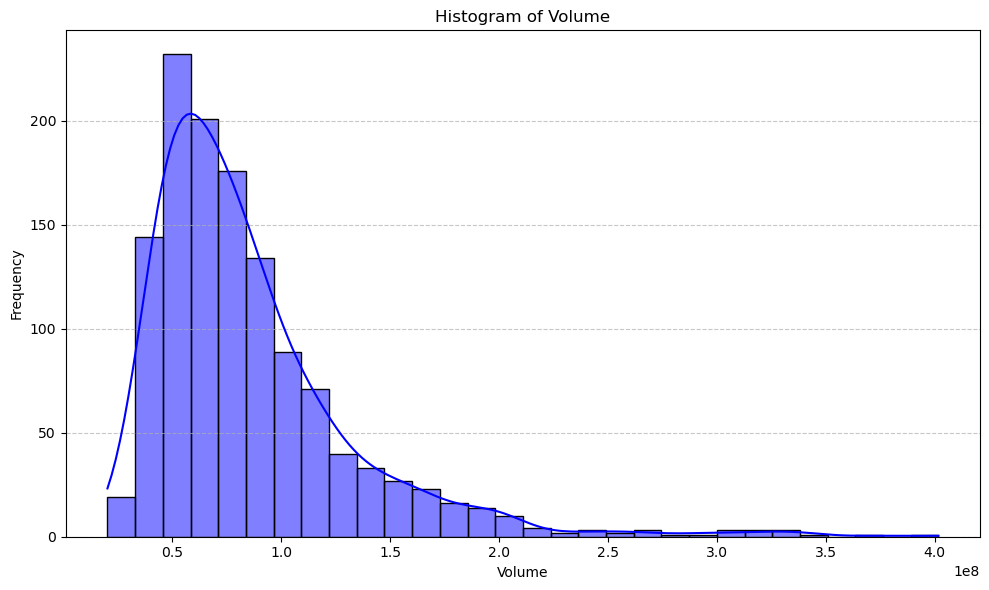

Skew Coefficient: 2.2698125481974287


,Volume
count,1.257000e+03
mean,8.565798e+07
std,4.778116e+07
min,2.025219e+07
25%,5.376350e+07
50%,7.353180e+07
75%,1.012356e+08
max,4.016932e+08


In [13]:
# Create a histogram of Volume
plt.figure(figsize=(10, 6))
sns.histplot(price_df['Volume'], bins=30, kde=True, color='blue')

# Customize the plot
plt.title('Histogram of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

skewCoef = price_df['Volume'].skew()
print(f"Skew Coefficient: {skewCoef}")

price_df[['Volume']].describe()

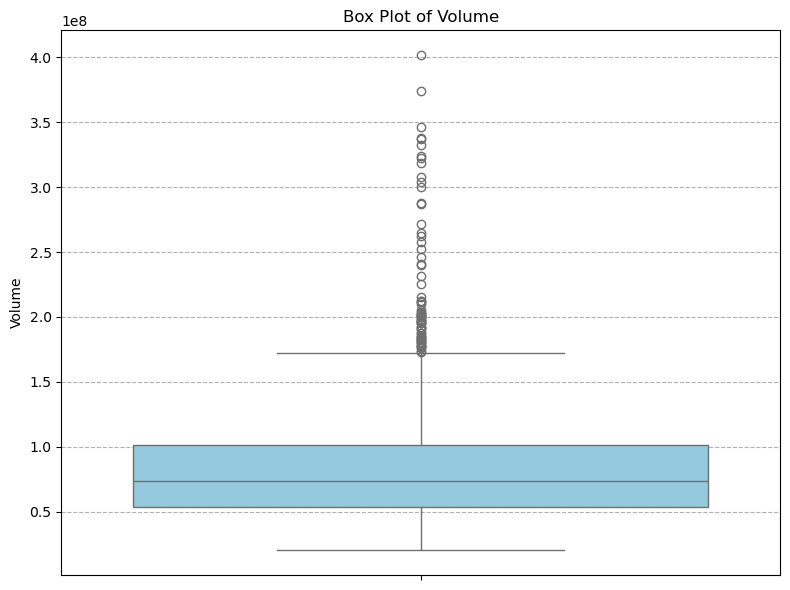

In [14]:
# Create a box plot for the Volume column
plt.figure(figsize=(8, 6))
sns.boxplot(data=price_df, y='Volume', color='skyblue')

# Customize the plot
plt.title('Box Plot of Volume')
plt.ylabel('Volume')
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

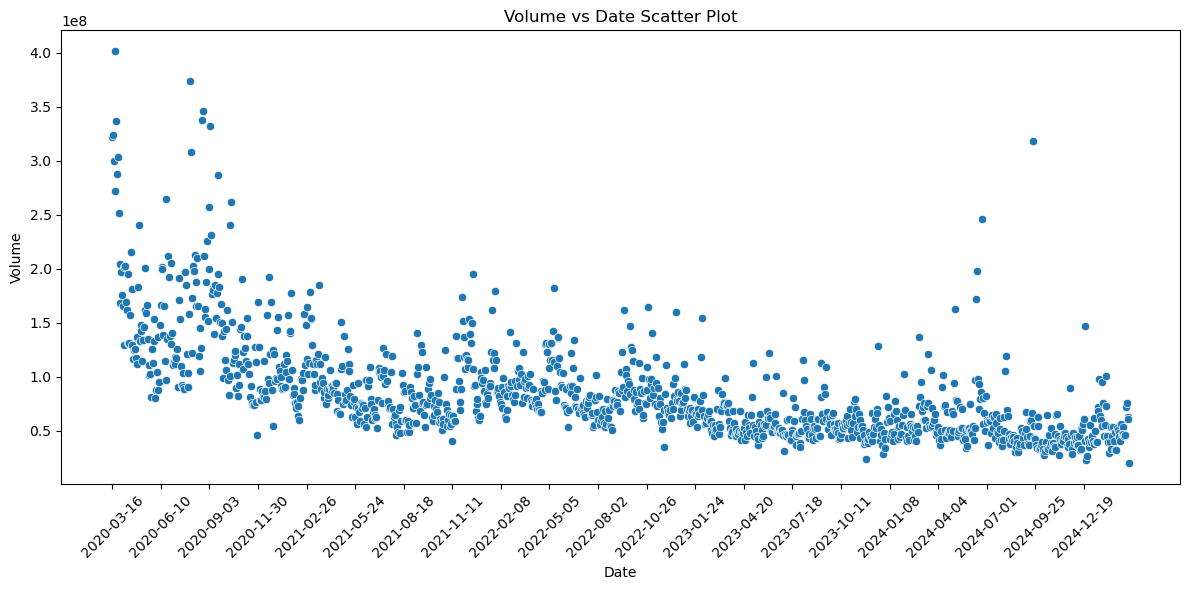

In [15]:
#Plot Volume
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot for Open

# Scatter plot for Volume
sns.scatterplot(data=price_df, x="Date", y="Volume", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Volume")
ax.set_title("Volume vs Date Scatter Plot")
ax.set_xticks(ax.get_xticks()[::60])  # Set x-axis ticks every 60 entries
ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#### Statistical Analysis of Volatility Index (VIX)
There is some above normal volatility at the beginning of the dataset, which will be excluded from the dataset during feature generation of historical time series data. 

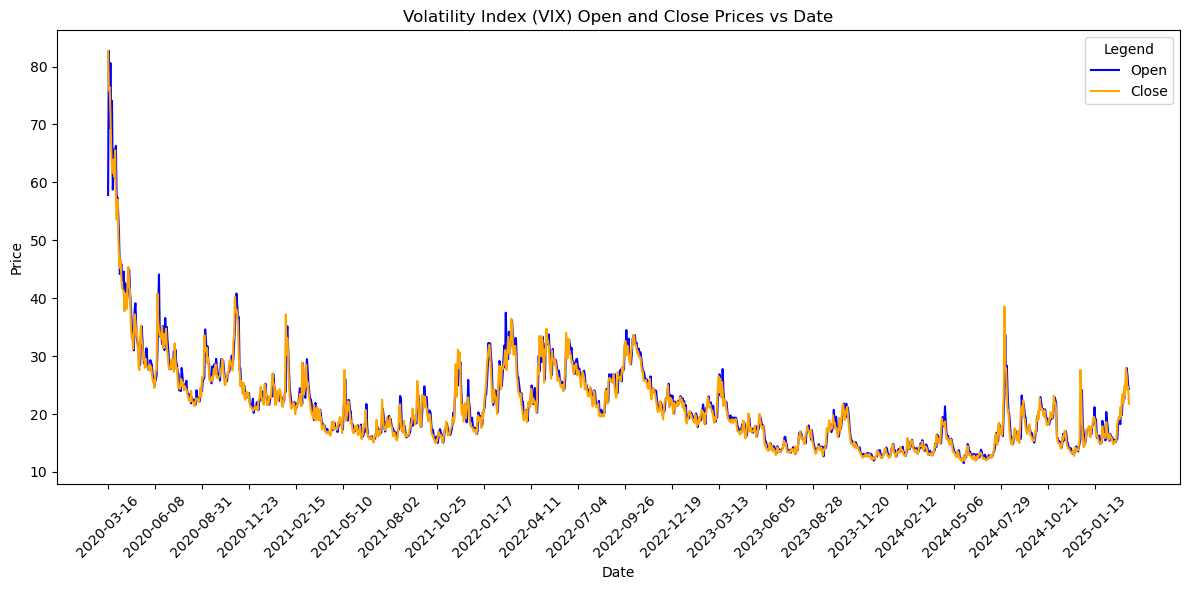

In [16]:
# Plot Open and Close on the same graph
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Open prices
sns.lineplot(data=vix_df, x="Date", y="Open", ax=ax, label="Open", color="blue")

# Plot Close prices
sns.lineplot(data=vix_df, x="Date", y="Close", ax=ax, label="Close", color="orange")

# Customize the plot
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("Volatility Index (VIX) Open and Close Prices vs Date")
ax.legend(title="Legend")
ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
ax.set_xticks(ax.get_xticks()[::60])  # Set x-axis ticks every 60 entries

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

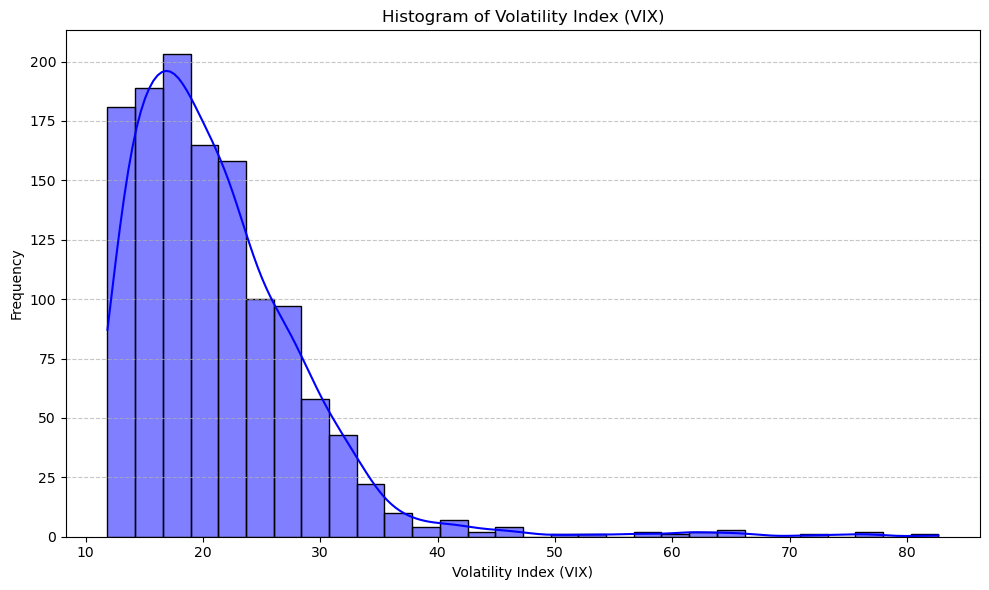

Skew Coefficient: 2.5602950046235846


,Close
count,1257.000000
mean,21.239905
std,7.773636
min,11.860000
25%,16.040001
50%,19.629999
75%,24.660000
max,82.690002


In [17]:
# Create a histogram of VIX
plt.figure(figsize=(10, 6))
sns.histplot(vix_df['Close'], bins=30, kde=True, color='blue')

# Customize the plot
plt.title('Histogram of Volatility Index (VIX)')
plt.xlabel('Volatility Index (VIX)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

skewCoef = vix_df['Close'].skew()
print(f"Skew Coefficient: {skewCoef}")

vix_df[['Close']].describe()

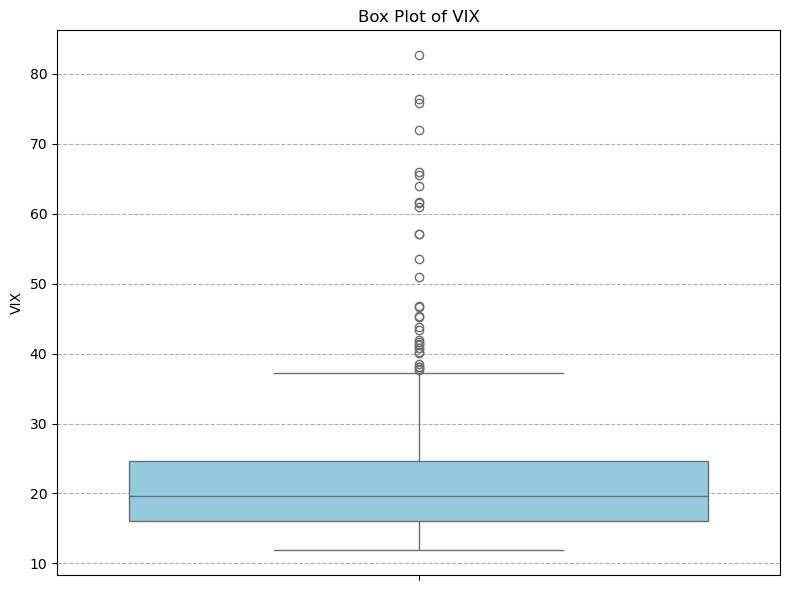

In [18]:
# Create a box plot for the VIX
plt.figure(figsize=(8, 6))
sns.boxplot(data=vix_df, y='Close', color='skyblue')

# Customize the plot
plt.title('Box Plot of VIX')
plt.ylabel('VIX')
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

#### Examine Dividends

Dividends appear to be offered at regular intervals of increasing value. From the calculated field "Days Since Dividend", it was seen that there are dividends are generally issued every 90 days, however there are exceptions. This is because dividends are issued quarterly and there is some variation in the schedule due to holidays, etc.

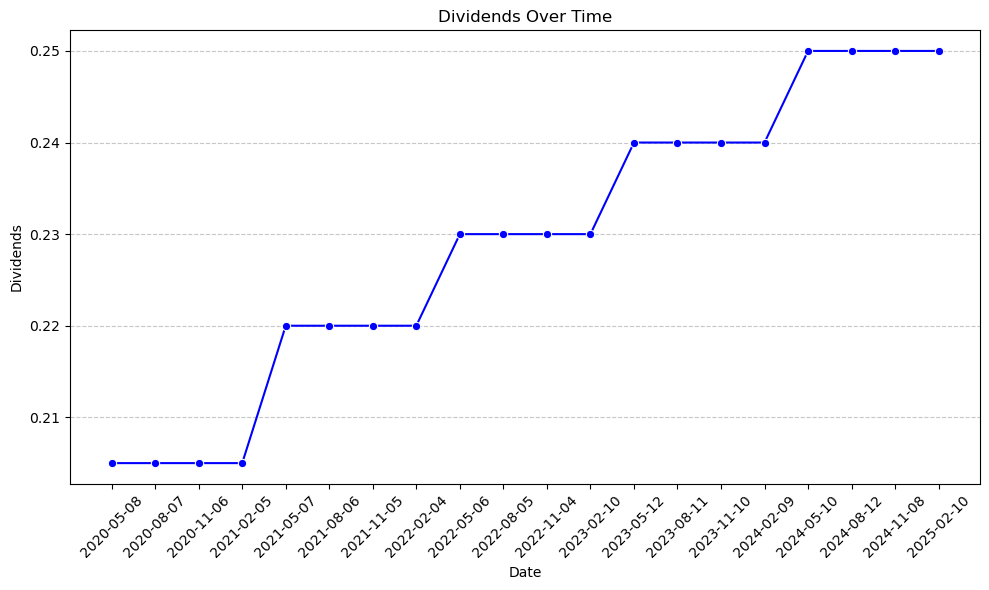

,Date,Dividends
0,2020-05-08,0.205
1,2020-08-07,0.205
2,2020-11-06,0.205
3,2021-02-05,0.205
4,2021-05-07,0.220
5,2021-08-06,0.220
6,2021-11-05,0.220
7,2022-02-04,0.220
8,2022-05-06,0.230
9,2022-08-05,0.230


In [19]:
#Examine Dividends
# Create an x-y chart for dividends
plt.figure(figsize=(10, 6))
sns.lineplot(data=dividend_df, x="Date", y="Dividends", marker="o", color="blue")

# Customize the plot
plt.title("Dividends Over Time")
plt.xlabel("Date")
plt.ylabel("Dividends")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

dividend_df

## Data Preparation

Relevant features for training will be selected. Additionally feature engineering will need to be done for to shift values for time series analysis. Additionally, key metrics such as Horizon indexes can be calculated from the source data. 

The following steps are followed:

1. Construct Data - Derive features 
2. Integrate Data - Produce Dataset 
3. Select Data - Identify Features that drive the result


As the data was of good quality, data cleaning and data formatting was not required. All features examined were numeric in nature. The date format in all files were consistent in format allowing it to be used as an index. All files had values listed in temporal order. 


### 1. Construct Data - Derive features 

To perform the analysis, feature engineering is required to bring historic and calculated values into one row of the DataFrame to train the model. 

1. Previous Close to Open
2. Volume 1-day, 2-day
3. Close 1-day, 2-day, 3-day, 1-week, 2-week, 1-month
4. Delta 1-day, 2-day, 3-day, 1-week, 2-week, 1-month
5. VIX 1-day, 2-day, 3-day
6. Last Dividend Amount, Last Dividend Date, Days Since Dividend
7. Horizon Ratio 2-day, 1-week, 1-month
8. Increases 1-day, 2-day, 1-week, 1-month
9. Daily Close Change, Up or Down

The target classification (UP, DOWN) is obtained by subtracting the day's close from the previous day.

In [20]:
#Handle Shifted Time Calculated Fields

derived_df = pd.DataFrame()

# 1. Previous Close to Open
derived_df['Previous Close to Open'] = price_df['Open'] - price_df['Close'].shift(1)

# 2. Volume 1-day, 2-day
derived_df['Volume 1-day'] = price_df['Volume'].shift(1)
derived_df['Volume 2-day'] = price_df['Volume'].shift(2)

# 3. Close 1-day, 2-day, 3-day, 1-week, 2-week, 1-month
derived_df['Close 1-day'] = price_df['Close'].shift(1)
derived_df['Close 2-day'] = price_df['Close'].shift(2)
derived_df['Close 3-day'] = price_df['Close'].shift(3)
derived_df['Close 1-week'] = price_df['Close'].shift(5)
derived_df['Close 2-week'] = price_df['Close'].shift(10)
derived_df['Close 1-month'] = price_df['Close'].shift(20)

# 4. Delta 1-day, 2-day, 3-day, 1-week, 2-week, 1-month
derived_df['Delta 1-day'] = price_df['Open'] - price_df['Open'].shift(1)
derived_df['Delta 2-day'] = price_df['Open'] - price_df['Open'].shift(2)
derived_df['Delta 3-day'] = price_df['Open'] - price_df['Open'].shift(3)
derived_df['Delta 1-week'] = price_df['Open'] - price_df['Open'].shift(5)
derived_df['Delta 2-week'] = price_df['Open'] - price_df['Open'].shift(10)
derived_df['Delta 1-month'] = price_df['Open'] - price_df['Open'].shift(20)

# 7. Horizon Ratio 2-day, 1-week, 1-month
derived_df['Horizon Ratio 2-day'] = price_df['Open'] / price_df['Close'].shift(1).rolling(window=2).mean()
derived_df['Horizon Ratio 1-week'] = price_df['Open'] / price_df['Close'].shift(1).rolling(window=5).mean()
derived_df['Horizon Ratio 1-month'] = price_df['Open'] / price_df['Close'].shift(1).rolling(window=20).mean()

# 9. Daily Close Change, Up or Down
derived_df['Daily Close Change'] = price_df['Close'].diff()
derived_df['Up or Down'] = np.where(derived_df['Daily Close Change'] > 0, 'UP', 'DOWN')

# 8. Increases 1-day, 2-day, 1-week, 1-month
derived_df['Increases 1-day'] = np.where(derived_df['Up or Down'].shift(1)=='UP', 1, 0)
derived_df['Increases 2-day'] = derived_df['Increases 1-day'].rolling(window=2).sum()
derived_df['Increases 1-week'] = derived_df['Increases 1-day'].rolling(window=5).sum()
derived_df['Increases 1-month'] = derived_df['Increases 1-day'].rolling(window=21).sum()

# Add 'Date' column to the front
derived_df.insert(0, 'Date', price_df['Date'])

derived_df [160:165]



,Date,Previous Close to Open,Volume 1-day,Volume 2-day,Close 1-day,Close 2-day,Close 3-day,Close 1-week,Close 2-week,Close 1-month,...,Delta 1-month,Horizon Ratio 2-day,Horizon Ratio 1-week,Horizon Ratio 1-month,Daily Close Change,Up or Down,Increases 1-day,Increases 2-day,Increases 1-week,Increases 1-month
160,2020-10-30,-4.260002,146129200.0,143937800.0,115.320000,111.199997,116.599998,115.040001,119.019997,113.019997,...,-1.830001,0.980576,0.968755,0.951084,-6.459999,DOWN,1,1.0,3.0,10.0
161,2020-11-02,0.250000,190272600.0,146129200.0,108.860001,115.320000,111.199997,115.050003,115.980003,116.500000,...,-4.800003,0.973414,0.962118,0.936052,-0.090004,DOWN,0,1.0,3.0,9.0
162,2020-11-03,0.890007,122866900.0,190272600.0,108.769997,108.860001,115.320000,116.599998,117.510002,113.160004,...,-6.039993,1.007766,0.977798,0.943901,1.670005,UP,0,0.0,2.0,9.0
163,2020-11-04,3.699997,107624400.0,122866900.0,110.440002,108.769997,108.860001,111.199997,116.870003,115.080002,...,-0.480004,1.041376,1.029048,0.983614,4.509995,UP,1,1.0,2.0,9.0
164,2020-11-05,3.000000,138235500.0,107624400.0,114.949997,110.440002,108.769997,115.320000,115.750000,114.970001,...,1.699997,1.046630,1.056256,1.016504,4.080002,UP,1,2.0,3.0,10.0


In [21]:
#derived_df.to_csv('draft/derived_data.csv', index=False)

In [22]:
#Identify ration of up days to down days. 
#This is for the executive summary and findings.

# Calculate counts of UP and DOWN
up_down_counts = derived_df['Up or Down'].value_counts()

# Calculate the ratio of UP to DOWN
up_down_ratio = up_down_counts['UP'] / up_down_counts['DOWN']

# Display the counts and ratio
print(f"Counts:\n{up_down_counts}")
print(f"Ratio of UP to DOWN: {up_down_ratio:.2f}")

Counts:
Up or Down
UP      667
DOWN    590
Name: count, dtype: int64
Ratio of UP to DOWN: 1.13


In [23]:
# 5. VIX 1-day, 2-day, 3-day

derived_vix_df = pd.DataFrame()
derived_vix_df = price_df['Date']
derived_vix_df = pd.merge(derived_vix_df, vix_df[['Date', 'Close']], on='Date', how='left')
derived_vix_df['VIX 1-day'] = derived_vix_df['Close'].shift(1)
derived_vix_df['VIX 2-day'] = derived_vix_df['Close'].shift(2)
derived_vix_df['VIX 3-day'] = derived_vix_df['Close'].shift(3)
derived_vix_df.drop(columns=['Close'], inplace=True)

derived_vix_df

,Date,VIX 1-day,VIX 2-day,VIX 3-day
0,2020-03-16,NaN,NaN,NaN
1,2020-03-17,82.690002,NaN,NaN
2,2020-03-18,75.910004,82.690002,NaN
3,2020-03-19,76.449997,75.910004,82.690002
4,2020-03-20,72.000000,76.449997,75.910004
...,...,...,...,...
1252,2025-03-10,23.370001,24.870001,21.930000
1253,2025-03-11,27.860001,23.370001,24.870001
1254,2025-03-12,26.920000,27.860001,23.370001
1255,2025-03-13,24.230000,26.920000,27.860001


**Last Dividend Amount, Last Dividend Date, Days Since Dividend**

Due to the complexity of merging the dividend data and producing these derived attributes, it was considered to omit these features from the analysis. Additionally when observing the relative importance of these factors using PCA, dividend values showed up in the bottom of the list when evaluated by their magnitude (absolute values of coefficients). However, when examining the feature importance list from the Decision Tree model, the number of days since dividend showed up as one of the top features leading to its inclusion. 

In [24]:
# 6. Last Dividend Amount, Last Dividend Date, Days Since Dividend

derived_dividend_df = pd.DataFrame()

# Ensure 'Date' columns are in datetime format
derived_dividend_df['Date'] = price_df['Date']

# Merge dividend data into derived_dividend_df
derived_dividend_df = pd.merge(derived_dividend_df, dividend_df[['Date', 'Dividends']], on='Date', how='left')

# Forward-fill the last dividend date and value
derived_dividend_df['Last Dividend Date'] = derived_dividend_df['Date'].where(derived_dividend_df['Dividends'].notna()).ffill()
derived_dividend_df['Last Dividend Amount'] = derived_dividend_df['Dividends'].ffill()

derived_dividend_df['Days Since Dividend'] = (pd.to_datetime(derived_dividend_df['Date']) - pd.to_datetime(derived_dividend_df['Last Dividend Date']) ).dt.days

# Drop the 'Dividends' column
derived_dividend_df.drop(columns=['Dividends'], inplace=True)

derived_dividend_df.tail(5)

,Date,Last Dividend Date,Last Dividend Amount,Days Since Dividend
1252,2025-03-10,2025-02-10,0.25,28.0
1253,2025-03-11,2025-02-10,0.25,29.0
1254,2025-03-12,2025-02-10,0.25,30.0
1255,2025-03-13,2025-02-10,0.25,31.0
1256,2025-03-14,2025-02-10,0.25,32.0


### 2. Integrate Data - Produce Dataset 

Datasets are combined. Rows with NAs in calculated values due to missing historic values at the beginning of the dataset are removed. A total of 1218 records remain, meeting our training threshold of at least 1000 records. 

In [25]:
# Merge all derived dataframes
nom_data = price_df.copy(deep=True)

nom_data = pd.merge(nom_data, derived_df, on='Date', how='left') 
nom_data = pd.merge(nom_data, derived_dividend_df, on='Date', how='left') 
nom_data = pd.merge(nom_data, derived_vix_df, on='Date', how='left') 

renamed_vix_df = vix_df[['Date', 'Open', 'Close']].rename(columns={'Open': 'VIX Open', 'Close': 'VIX Close'})
nom_data = pd.merge(nom_data, renamed_vix_df , on='Date', how='left') 

#Remove rows with NAs. This is due to missing historic values at the beginning of the dataset
nom_data = nom_data.dropna()
nom_data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Previous Close to Open,Volume 1-day,Volume 2-day,...,Increases 1-week,Increases 1-month,Last Dividend Date,Last Dividend Amount,Days Since Dividend,VIX 1-day,VIX 2-day,VIX 3-day,VIX Open,VIX Close
38,2020-05-08,76.410004,77.587502,76.072502,77.532501,75.465782,133838400,0.475006,115215200.0,142333600.0,...,4.0,14.0,2020-05-08,0.205,0.0,31.440001,34.119999,33.610001,30.139999,27.980000
39,2020-05-11,77.025002,79.262497,76.809998,78.752502,76.653259,145946400,-0.507499,133838400.0,115215200.0,...,5.0,14.0,2020-05-08,0.205,3.0,27.980000,31.440001,34.119999,28.459999,27.570000
40,2020-05-12,79.457497,79.922501,77.727501,77.852501,75.777260,162301200,0.704995,145946400.0,133838400.0,...,5.0,14.0,2020-05-08,0.205,4.0,27.570000,27.980000,31.440001,28.469999,33.040001
41,2020-05-13,78.037498,78.987503,75.802498,76.912498,74.862305,200622400,0.184997,162301200.0,145946400.0,...,4.0,13.0,2020-05-08,0.205,5.0,33.040001,27.570000,27.980000,32.740002,35.279999
42,2020-05-14,76.127502,77.447502,75.382500,77.385002,75.322205,158929200,-0.784996,200622400.0,162301200.0,...,3.0,12.0,2020-05-08,0.205,6.0,35.279999,33.040001,27.570000,35.160000,32.610001


### 3. Select Data - Identify Features that drive the result

#### List of Numeric Features

The list below consists of the features List used for training.  Training features cannot include future data that is not available at the time the model is trained and used to predict future outcome. At this time, there were only numerical features present in the source training data. 

In [26]:
#Only Numerical Features in this model. Scale to compare factors. 
#The preprocessor removes fields not involved in training the model


numerical_features = [ 'Open',
             'Volume 1-day', 'Volume 2-day', 
             'Close 1-day', 'Close 2-day','Close 3-day' ,
             'Close 1-week' ,'Close 2-week' ,'Close 1-month',
             'Last Dividend Amount' ,
             'Days Since Dividend' ,
             'Horizon Ratio 2-day',	'Horizon Ratio 1-week', 
             'Horizon Ratio 1-month',
             'Increases 1-day',	'Increases 2-day',	'Increases 1-week',	'Increases 1-month',
             'Delta 1-day', 'Delta 2-day', 'Delta 3-day', 'Delta 1-week', 'Delta 2-week', 'Delta 1-month',
             'VIX 1-day', 'VIX 2-day','VIX 3-day',
             'VIX Open'
             ]

preprocessor = ColumnTransformer(
    transformers=[ 
        ('scal', StandardScaler(), numerical_features)
    ], remainder='drop'
)

#### Correlation Heatmap

A correlation heatmap was produced to gain a general understanding of which features are important and correlated with price changes, as well as to identify any highly correlated features that may be removed to avoid collinearity issues and enhance model performance.

While a correlation factor of around 0.6 between input features and the target is typically considered strong, the somewhat volatile nature of the data yielded maximum correlation values of approximately 0.36 and 0.42. These were associated with the ratio of the two-day average price change and the previous day’s price, respectively. This finding suggests some market momentum, where price increases on previous days can help predict continued upward movement.

High correlation was observed among features drawn from similar timeframes. For instance, as expected, stock prices within the same week tended to exhibit similar values.

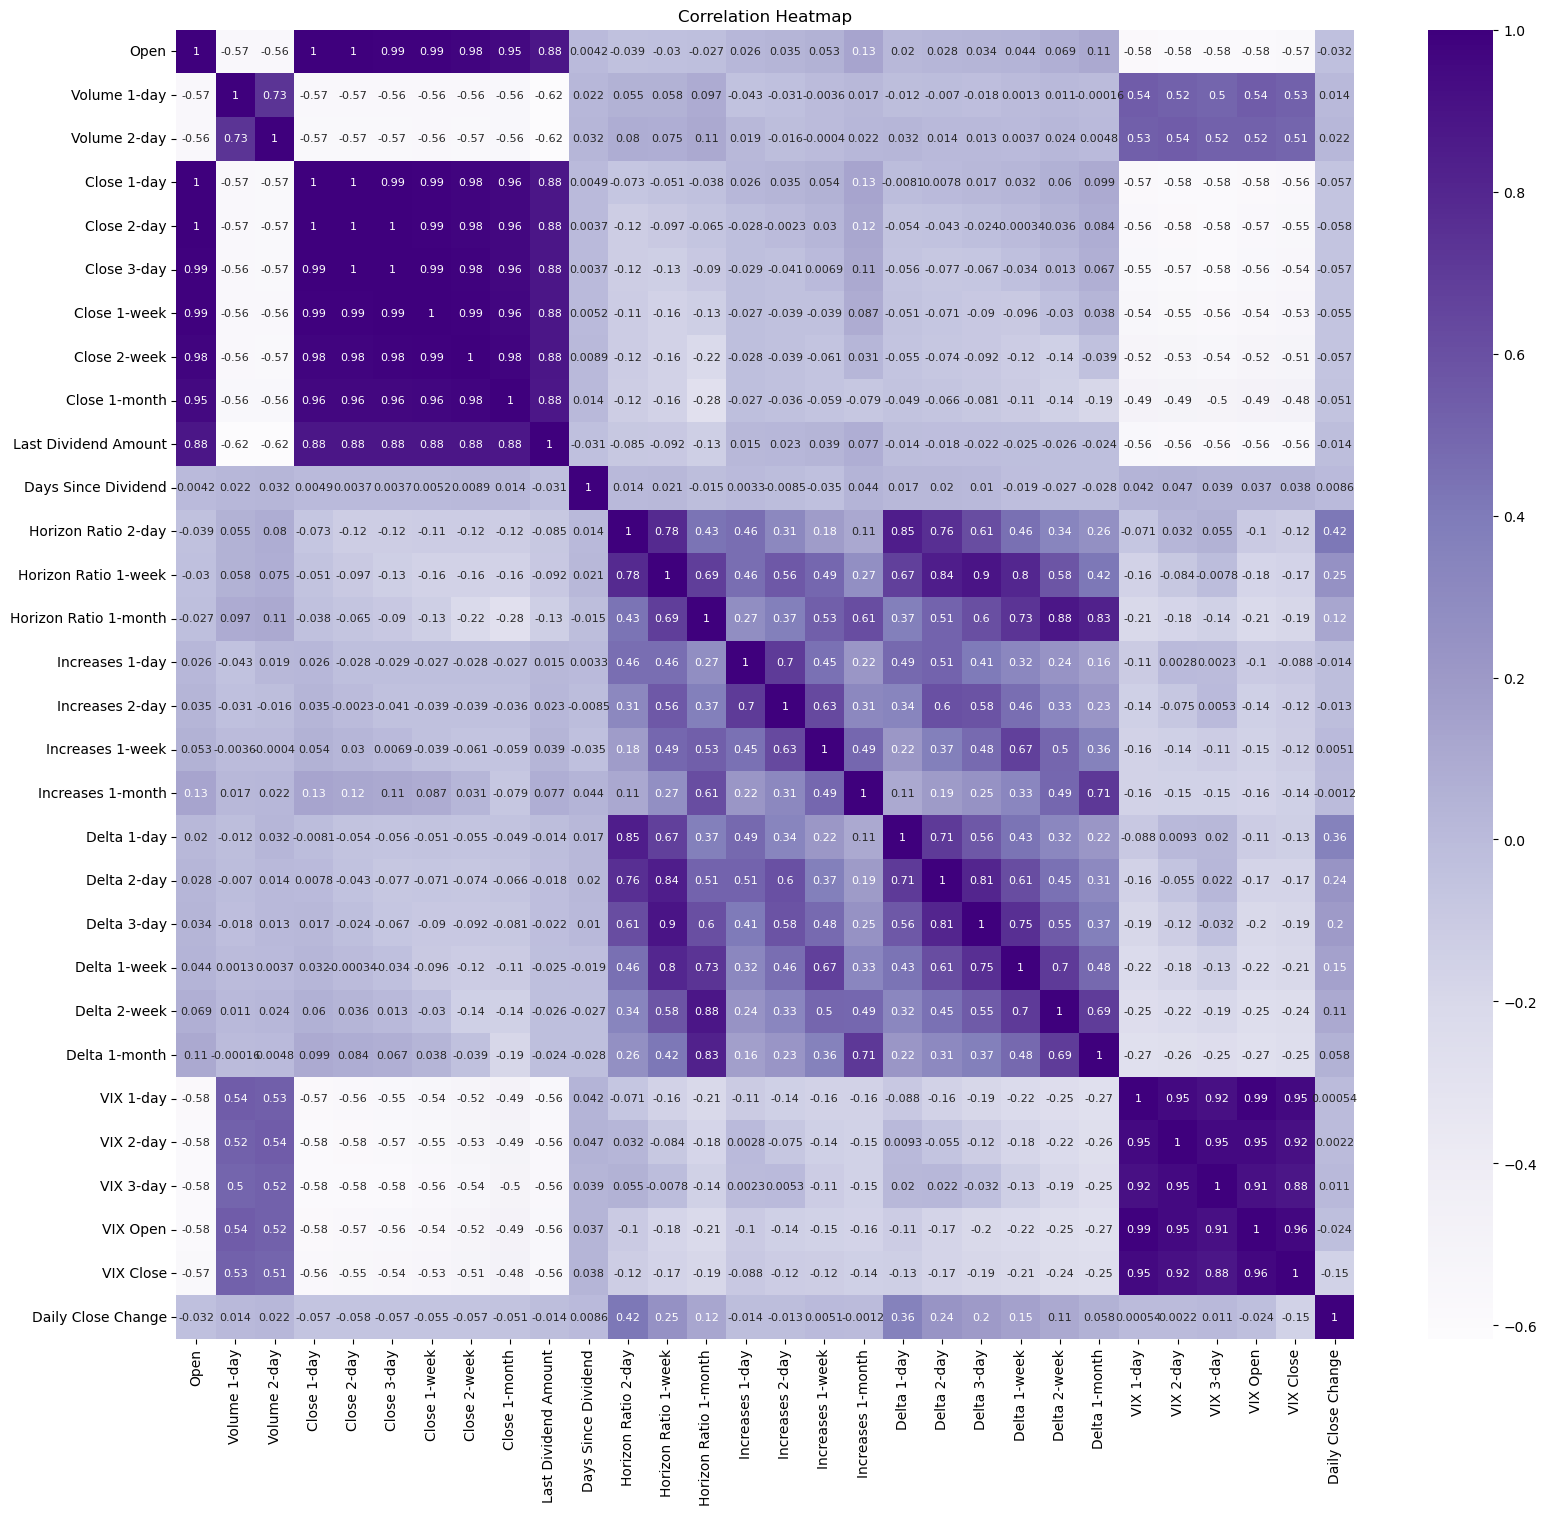

In [27]:
#Correlation Heatmap
predict_features = ['VIX Close', 'Daily Close Change'] #These values are not available at the time of prediction

combined_features = numerical_features + predict_features
corr_data = nom_data[combined_features]

#Correlation
corr = corr_data.corr()
plt.figure(figsize=(19,17), facecolor ='w')
sns.heatmap(corr, annot=True, cmap='Purples', annot_kws={"size": 8}) 
plt.title('Correlation Heatmap')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()



#### Distribution of Deltas in Closing Prices

 While the overall stock price does not follow a standard (bell-shaped) distribution, the daily price changes (deltas) appear to form an approximately bell-shaped curve. This indicates that small corrections in the stock value occur more frequently, whereas large price changes—either positive or negative—are relatively rare.

Standard Deviation was 2.80 and the maximum change on a particular day was $14.03. Additionally, the mean of the distribution is slightly offset to the right (around 0.11), which aligns with the observation that this stock has generally been trending upward over the examined period.

Although not explored here, future research could leverage this distribution to estimate the potential magnitude of price changes, thereby offering additional insights for traders.

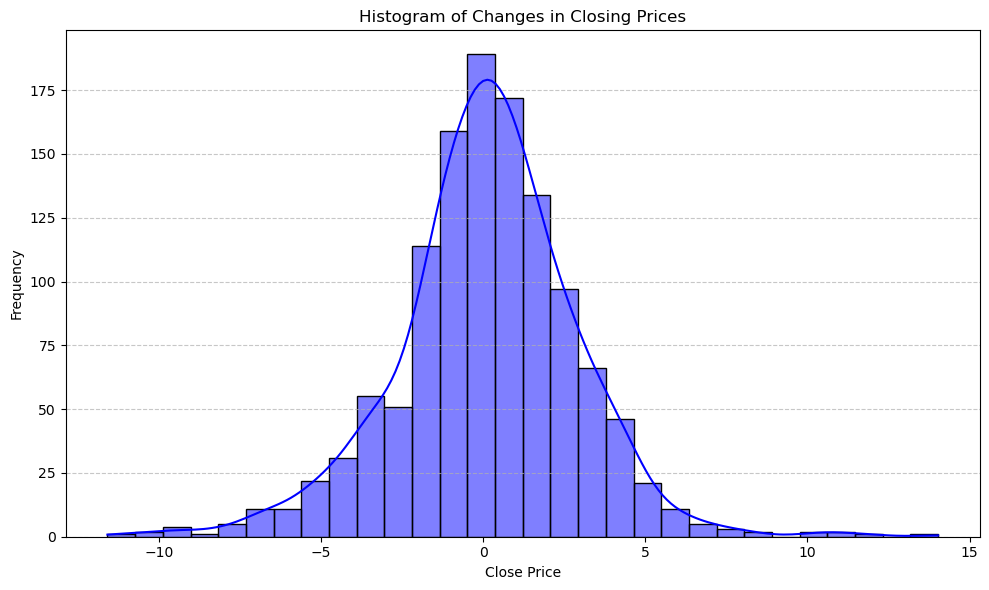

,Daily Close Change
count,1219.000000
mean,0.111095
std,2.798601
min,-11.590011
25%,-1.358749
50%,0.169998
75%,1.690002
max,14.029999


In [28]:

# Create a histogram of the Daily Close Change
plt.figure(figsize=(10, 6))
sns.histplot(nom_data['Daily Close Change'], bins=30, kde=True, color='blue')

# Customize the plot
plt.title('Histogram of Changes in Closing Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig('images/out/histogram_daily_close_change.png', dpi=300, bbox_inches='tight')
plt.show()

nom_data[['Daily Close Change']].describe()

## Modeling

With the whether the stock price will go up or down as the target, different regression models will be evaluated. As part of the models, different parameters will be explored and the findings will be cross-validated. 

1. Select Modeling Technique
2. Generate Test Design - Split Test and Training Data
3. Build Model
4. Assess Model




### 1. Select Modeling Technique 

Various categorization models are evaluated. Metrics are collected. These metrics will be applied to the testing (dev) set as there can be overfitting with the training set. The following evaluation metrics will be used to rate each model:



#### Evaluation Metrics

The trader would like to maximize the number of True Positives which represent days that the model predicted and in fact the stock went up.  The following should be minimized: (1) False Positives can be labelled as "Costly Mistakes" because those are days where the model indicated a purchase should be made and money was lost as the price went down. (2) Missed Opportunities are represented by False Negatives as those are days that the stock value increased but the model did not indicate a purchase should be made. 

True Negatives are irrelevant as in this scenario as a purchase would not have been made. 
<br><br>

<center>
    <img src = "images/wikipedia-confusion_matrix.png" width = 70%/>
</center>
<center>Source: Wikipedia </center>

The following evaluation metrics are considered:

**Accuracy Score**

Accuracy is the number of correct predictions divided by the number of predictions and is a good starting point for general effectiveness of the model. However there are better metrics for this use case. 
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$


**Precision Score**

In this scenario, we only buy when the model tells us to. We want to minimize the number of false positives as false positives cause us to lose money. Recall is the ratio of true positives over true and false positives.  This metric correctly penalizes false positives but there may be some missed opportunities in the form of false negatives. 
$$
\text{Precision} = \frac{TP}{TP + FP}
$$

**Recall Score**

Defined as the ratio of true positives over true positives and false negatives, this metric helps us catch all opportunities as it penalizes missed opportunities (false negatives). But it misses on minimizing costly mistakes (false negatives).

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

**F1 Score**

Because we want to maximize true positives and minimize missed opportunities(FN) and costly mistakes (FP), the F1 score is optimal. This metric  also known as a threat risk score and optimizes detecting an event. By definition, the metric maximizes TP by putting it in the numerator and minimizes FN and FP by putting it in the denominator. TN is omitted as it is not required.
$$
F_1 = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

$$
F_1 = \frac{2 \times TP}{2 \times TP + FP + FN}
$$
<br><br>

The desired confusion matrix for the scenario can be seen here. UP represents a day where the price increased, and DOWN represents a day where the price decreased. 

<center>
 <img src = images/IdealConfusionMatrix.png />
</center>

In [29]:
#Build Cross Validation Table to compare metrics of different models
modeling_cross_validation = pd.DataFrame(columns=[
    "Model Name", 
    "Train Time (sec)", 
    "Train Predict Time (sec)",
    "Train Accuracy",
    "Test Accuracy", 
    "Test Recall Score", "Test Precision Score", "Test F1 Score (Threat Det)" ])

modeling_cross_validation

,Model Name,Train Time (sec),Train Predict Time (sec),Train Accuracy,Test Accuracy,Test Recall Score,Test Precision Score,Test F1 Score (Threat Det)


In [30]:
# Plot Confusion Matrix
def plot_confusion_matrix(title,y_test,test_preds, deets=""):
    # Plot confusion matrix
    conf_matrix = metrics.confusion_matrix(y_test, test_preds, labels=['UP', 'DOWN'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['UP', 'DOWN'], yticklabels=['UP', 'DOWN'])
    plt.title(title + ' ' + deets)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('images/out/' + title.lower().replace(' ', '_') + '.png', dpi=300, bbox_inches='tight')
    plt.show()

### 2. Generate Test Design - Split Test and Training Data

The overall cleaned dataset will be split into a Training dataset used for training the models, and Dev Test dataset used to validate the model.  Twenty-five percent of the dataset will be used for Dev Test, and the remaining 75% will be used for training. 

In [31]:
#Generate Test Design
# Split Test and Train

X = nom_data[numerical_features]
y = nom_data['Up or Down'] 

train = nom_data.iloc[:-100]
test = nom_data.iloc[-100:]

# using the train test split function 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                   random_state=104,  
                                   test_size=0.25,  
                                   shuffle=True)

#Split with last 100
#X_train = X.iloc[:-100]
#X_test = X.iloc[-100:]
#y_train = y.iloc[:-100]
#y_test = y.iloc[-100:]


### 3. Build Model
Several models will be built. Accuracy will be used to assess each model. Training and Test errors will be recorded. Grid Search will be used to tune hyperparameters and perform the cross-validation. 


#### Perform PCA 
First, continuing with the Exploratory Data Analysis (EDA), Principal Component Analysis (PCA) is used to help feature selection by understanding which features are uncorrelated and important. This could be used so that data is not skewed and processing is faster. 

In [32]:
# Applying PCA function on training
# and testing set of X component

pca = PCA(n_components=5)
data_in=nom_data[numerical_features]
scaled_nom_data = StandardScaler().fit_transform(data_in)
pdax = pca.fit_transform(scaled_nom_data)

# Create a sorted list of features based on the sum of their absolute contributions across all principal components
features = data_in.columns
components = pca.components_

# Calculate the sum of absolute values of each feature's contribution across all components
feature_contributions = np.sum(np.abs(components), axis=0)

# Create a DataFrame for better visualization
contributions_df = pd.DataFrame({'Feature': features, 'Sum of Contributions': feature_contributions})

# Sort the DataFrame by the sum of contributions in descending order
sorted_contributions = contributions_df.sort_values(by='Sum of Contributions', ascending=False)

# Display sorted contributions
sorted_contributions



,Feature,Sum of Contributions
11,Horizon Ratio 2-day,1.054071
23,Delta 1-month,1.031869
15,Increases 2-day,0.990596
16,Increases 1-week,0.977477
18,Delta 1-day,0.958974
17,Increases 1-month,0.930793
24,VIX 1-day,0.918573
25,VIX 2-day,0.906614
14,Increases 1-day,0.895164
13,Horizon Ratio 1-month,0.894001


### 3. Build Models

Four models were considered, tuned and evaluated. 

* K Nearest Neighbors (KNN)
* Decision Tree
* Random Forest
* SVM

With the Ideal Scenario Confusion Matrix above in mind, the confusion matrix for each model can be used to evaluate performance. 

#### Model : K Nearest Neighbors (KNN)

A KNeighborsClassifier was created inside a pipeline as a default model to use as a baseline. 

In [33]:

knn_pipe = Pipeline([('transform', preprocessor), 
                     ('knn', KNeighborsClassifier())])

start = time.time()
knn_pipe.fit(X_train, y_train)
train_secs = time.time()-start 

start = time.time()
train_preds = knn_pipe.predict(X_train)
predict_secs = time.time()-start 

test_preds = knn_pipe.predict(X_test)

modeling_cross_validation.loc[len(modeling_cross_validation)] = [
    "K Nearest Neighbors", 
    train_secs, 
    predict_secs,
    accuracy_score(train_preds, y_train),
    accuracy_score (test_preds, y_test),
    metrics.recall_score(y_test, test_preds, pos_label='UP'),
    metrics.precision_score(y_test, test_preds, pos_label='UP'),
    metrics.f1_score(y_test, test_preds, pos_label='UP')
   ]

modeling_cross_validation


,Model Name,Train Time (sec),Train Predict Time (sec),Train Accuracy,Test Accuracy,Test Recall Score,Test Precision Score,Test F1 Score (Threat Det)
0,K Nearest Neighbors,0.017395,0.093432,0.714442,0.485246,0.517857,0.533742,0.52568


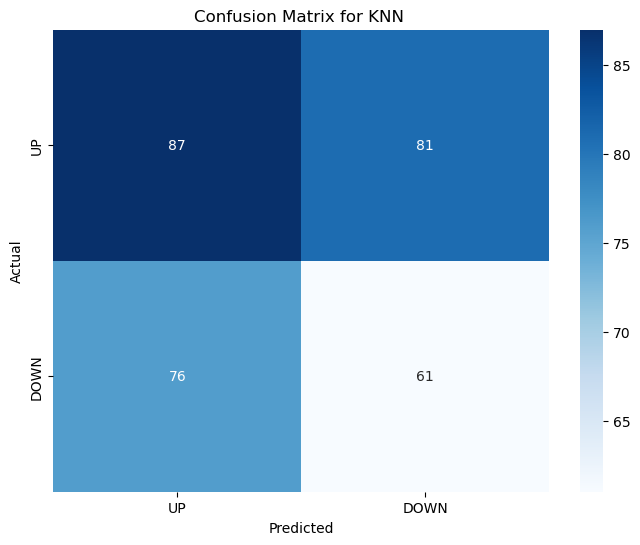

In [34]:
# Plot confusion matrix
plot_confusion_matrix('Confusion Matrix for KNN', y_test, test_preds)

#### Assess Model: KNN - Revise Parameter Settings 

GridSearch Cross Validation was used with the F1 evaluation metric to find the optimal hyperparameter for 'k' representing nearest neighbos. 

When compared with accuracy as a scoring metric, the results were the simiar. The GridSearch CV algorithm found that 91 nearest neighbors was the most optimal.

In [35]:

parameters_values = np.array(range(1,100))

parameters = {'knn__n_neighbors': parameters_values }

knn_pipe_search = GridSearchCV(estimator = knn_pipe, 
                               param_grid = parameters, 
                               scoring = "f1_micro",
                               cv = 5)

knn_pipe_search.fit(X_train, y_train)
knn_pipe_search.best_estimator_


Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('scal', StandardScaler(),
                                                  ['Open', 'Volume 1-day',
                                                   'Volume 2-day',
                                                   'Close 1-day', 'Close 2-day',
                                                   'Close 3-day',
                                                   'Close 1-week',
                                                   'Close 2-week',
                                                   'Close 1-month',
                                                   'Last Dividend Amount',
                                                   'Days Since Dividend',
                                                   'Horizon Ratio 2-day',
                                                   'Horizon Ratio 1-week',
                                                   'Horizon Ratio 1-month',
                                                   'Increases 1-day',
                                                   'Increases 2-day',
                                                   'Increases 1-week',
                                                   'Increases 1-month',
                                                   'Delta 1-day', 'Delta 2-day',
                                                   'Delta 3-day',
                                                   'Delta 1-week',
                                                   'Delta 2-week',
                                                   'Delta 1-month', 'VIX 1-day',
                                                   'VIX 2-day', 'VIX 3-day',
                                                   'VIX Open'])])),
                ('knn', KNeighborsClassifier(n_neighbors=92))])

In [36]:
gridsearch_output = pd.DataFrame({'CV accuracy': knn_pipe_search.cv_results_['mean_test_score'],
             'k': parameters_values})
fig = px.line(gridsearch_output, x = "k", y = "CV accuracy", title="KNN Tree Hyperparameter Tuning: CV Accuracy vs k-nearest neighbors")
fig.show()

In [37]:

start = time.time()
knn_pipe_search.best_estimator_.fit(X_train, y_train)
train_secs = time.time()-start 

start = time.time()
train_preds = knn_pipe_search.best_estimator_.predict(X_train)
predict_secs = time.time()-start 
test_preds = knn_pipe_search.best_estimator_.predict(X_test)


modeling_cross_validation.loc[len(modeling_cross_validation)] = [
    "K Nearest Neighbors Tuning - k: " + str(knn_pipe_search.best_params_['knn__n_neighbors']) , 
    train_secs, 
    predict_secs,
    accuracy_score(train_preds, y_train),
    accuracy_score (test_preds, y_test),
    metrics.recall_score(y_test, test_preds, pos_label='UP'),
    metrics.precision_score(y_test, test_preds, pos_label='UP'),
    metrics.f1_score(y_test, test_preds, pos_label='UP')
   ]

modeling_cross_validation


,Model Name,Train Time (sec),Train Predict Time (sec),Train Accuracy,Test Accuracy,Test Recall Score,Test Precision Score,Test F1 Score (Threat Det)
0,K Nearest Neighbors,0.017395,0.093432,0.714442,0.485246,0.517857,0.533742,0.52568
1,K Nearest Neighbors Tuning - k: 92,0.009342,0.027926,0.591904,0.544262,0.666667,0.574359,0.61708


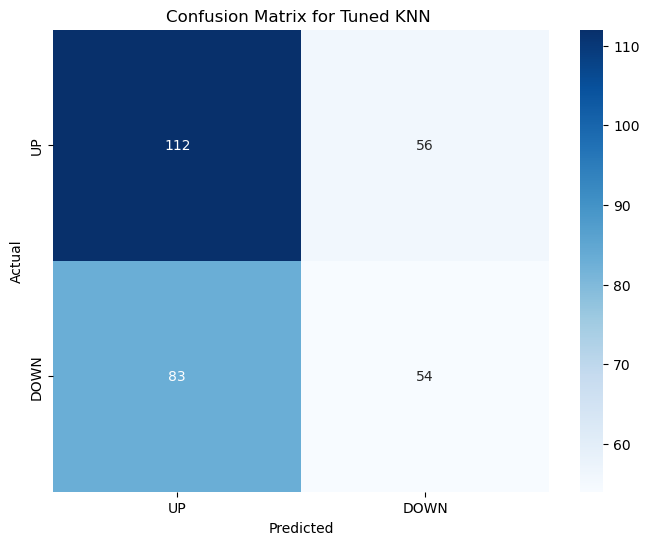

In [38]:
# Plot confusion matrix
plot_confusion_matrix('Confusion Matrix for Tuned KNN', y_test, test_preds)

#### Model: Decision Tree
Using default values, a DecisionTreeClassifier with the default 'gini' criterion was used and a tree of depth 17 was produced. The default setting produced a training accuracy of 1.0 suggesting some overfitting. 

In [39]:
dt_pipe = Pipeline([('transform', preprocessor), 
                     ('dtc',DecisionTreeClassifier())])

start = time.time()
dt_pipe.fit(X_train, y_train)
train_secs = time.time()-start 

start = time.time()
train_preds = dt_pipe.predict(X_train)
predict_secs = time.time()-start 
test_preds = dt_pipe.predict(X_test)

modeling_cross_validation.loc[len(modeling_cross_validation)] = [
    "Decision Tree -  Depth: " + str(dt_pipe['dtc'].get_depth()),
    train_secs, 
    predict_secs,
    accuracy_score(train_preds, y_train),
    accuracy_score (test_preds, y_test),
    metrics.recall_score(y_test, test_preds, pos_label='UP'),
    metrics.precision_score(y_test, test_preds, pos_label='UP'),
    metrics.f1_score(y_test, test_preds, pos_label='UP')
   ]

modeling_cross_validation

,Model Name,Train Time (sec),Train Predict Time (sec),Train Accuracy,Test Accuracy,Test Recall Score,Test Precision Score,Test F1 Score (Threat Det)
0,K Nearest Neighbors,0.017395,0.093432,0.714442,0.485246,0.517857,0.533742,0.525680
1,K Nearest Neighbors Tuning - k: 92,0.009342,0.027926,0.591904,0.544262,0.666667,0.574359,0.617080
2,Decision Tree - Depth: 17,0.024755,0.001525,1.000000,0.570492,0.619048,0.608187,0.613569


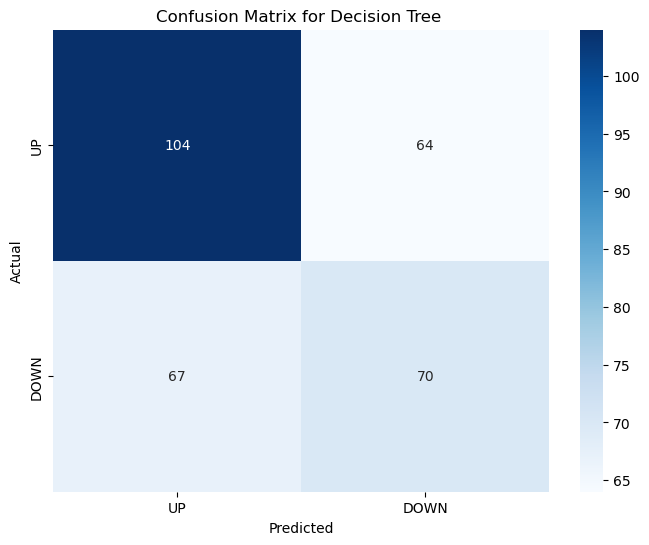

In [40]:
# Plot confusion matrix
plot_confusion_matrix('Confusion Matrix for Decision Tree', y_test, test_preds)

#### Assess Model: Decision Tree - Revise Parameter Settings 

Tuning the hyperparameter 'max_depth' using GridSearchCV identified a flat tree with a max_depth=1 as optimal with the training set. This reduced the training accuracy but increased test accuracy and F1 scores confirming that overfitting was previously happening.


In [41]:
parameters_values = np.array(range(1,33))
parameters = {'dtc__max_depth': parameters_values}


dtc_pipe_search = GridSearchCV(estimator = dt_pipe, 
                               param_grid = parameters, 
                               scoring = "f1_micro"
                               )

dtc_pipe_search.fit(X_train, y_train)
dtc_pipe_search.best_estimator_


Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('scal', StandardScaler(),
                                                  ['Open', 'Volume 1-day',
                                                   'Volume 2-day',
                                                   'Close 1-day', 'Close 2-day',
                                                   'Close 3-day',
                                                   'Close 1-week',
                                                   'Close 2-week',
                                                   'Close 1-month',
                                                   'Last Dividend Amount',
                                                   'Days Since Dividend',
                                                   'Horizon Ratio 2-day',
                                                   'Horizon Ratio 1-week',
                                                   'Horizon Ratio 1-month',
                                                   'Increases 1-day',
                                                   'Increases 2-day',
                                                   'Increases 1-week',
                                                   'Increases 1-month',
                                                   'Delta 1-day', 'Delta 2-day',
                                                   'Delta 3-day',
                                                   'Delta 1-week',
                                                   'Delta 2-week',
                                                   'Delta 1-month', 'VIX 1-day',
                                                   'VIX 2-day', 'VIX 3-day',
                                                   'VIX Open'])])),
                ('dtc', DecisionTreeClassifier(max_depth=1))])

In [42]:


start = time.time()
dtc_pipe_search.best_estimator_.fit(X_train, y_train)
train_secs = time.time()-start 

start = time.time()
train_preds = dtc_pipe_search.best_estimator_.predict(X_train)
predict_secs = time.time()-start 
test_preds = dtc_pipe_search.best_estimator_.predict(X_test)


modeling_cross_validation.loc[len(modeling_cross_validation)] = [
    "Decision Tree Tuning - Max Depth: " + str(dtc_pipe_search.best_estimator_['dtc'].tree_.max_depth ), 
    train_secs, 
    predict_secs,
    accuracy_score(train_preds, y_train),
    accuracy_score (test_preds, y_test),
    metrics.recall_score(y_test, test_preds, pos_label='UP'),
    metrics.precision_score(y_test, test_preds, pos_label='UP'),
    metrics.f1_score(y_test, test_preds, pos_label='UP')
   ]

modeling_cross_validation



,Model Name,Train Time (sec),Train Predict Time (sec),Train Accuracy,Test Accuracy,Test Recall Score,Test Precision Score,Test F1 Score (Threat Det)
0,K Nearest Neighbors,0.017395,0.093432,0.714442,0.485246,0.517857,0.533742,0.525680
1,K Nearest Neighbors Tuning - k: 92,0.009342,0.027926,0.591904,0.544262,0.666667,0.574359,0.617080
2,Decision Tree - Depth: 17,0.024755,0.001525,1.000000,0.570492,0.619048,0.608187,0.613569
3,Decision Tree Tuning - Max Depth: 1,0.009562,0.001461,0.631291,0.606557,0.702381,0.627660,0.662921


In [43]:
dtc_pipe_search.best_estimator_['dtc'].tree_.max_depth

1

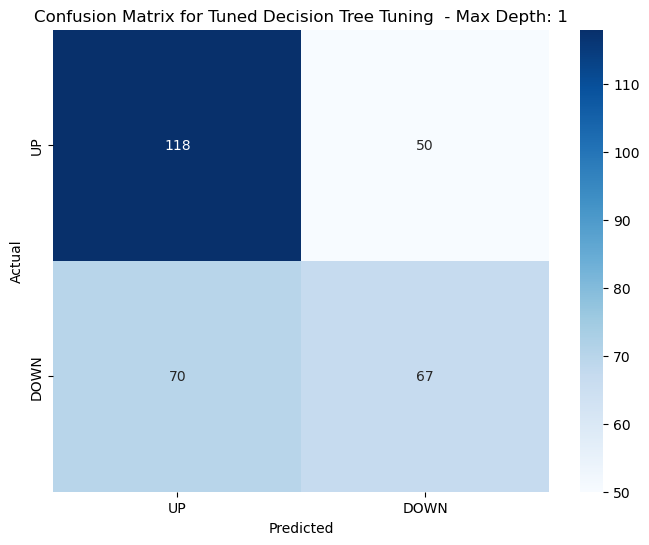

In [44]:
# Plot confusion matrix
plot_confusion_matrix('Confusion Matrix for Tuned Decision Tree Tuning', 
                      y_test, test_preds, 
                      deets=" - Max Depth: " + str(dtc_pipe_search.best_estimator_['dtc'].tree_.max_depth ))

In [45]:
# Extract feature importances from the decision tree
feature_importances = dt_pipe['dtc'].feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Decision Tree Feature': numerical_features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
sorted_importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
sorted_importance_df

,Decision Tree Feature,Importance
11,Horizon Ratio 2-day,0.165469
19,Delta 2-day,0.070539
10,Days Since Dividend,0.062554
24,VIX 1-day,0.062026
1,Volume 1-day,0.059867
23,Delta 1-month,0.056363
21,Delta 1-week,0.051693
12,Horizon Ratio 1-week,0.051410
20,Delta 3-day,0.050386
13,Horizon Ratio 1-month,0.047937


#### Model: Random Forest Classifier
To avoid the overfitting issues seen in the decision tree, the RandomForestClassifier was used with n_estimators = 100 and min_samples_split=100 to ensure a reasonable division of the training set. 

In [46]:
#Random Forest Classifier
rfc_pipe = Pipeline([('transform', preprocessor), 
                     ('rfc', RandomForestClassifier(n_estimators=100,
                                                    min_samples_split=100,random_state=42))])

start = time.time()
rfc_pipe.fit(X_train, y_train)
train_secs = time.time()-start 

start = time.time()
train_probs = rfc_pipe.predict_proba(X_train)[:, 1]
train_preds = np.where(train_probs > 0.6, 'UP', 'DOWN')
predict_secs = time.time()-start 
test_preds = rfc_pipe.predict(X_test)

modeling_cross_validation.loc[len(modeling_cross_validation)] = [
    "Random Forest Classifier", 
    train_secs, 
    predict_secs,
    accuracy_score(train_preds, y_train),
    accuracy_score (test_preds, y_test),
    metrics.recall_score(y_test, test_preds, pos_label='UP'),
    metrics.precision_score(y_test, test_preds, pos_label='UP'),
    metrics.f1_score(y_test, test_preds, pos_label='UP')
   ]

modeling_cross_validation

,Model Name,Train Time (sec),Train Predict Time (sec),Train Accuracy,Test Accuracy,Test Recall Score,Test Precision Score,Test F1 Score (Threat Det)
0,K Nearest Neighbors,0.017395,0.093432,0.714442,0.485246,0.517857,0.533742,0.525680
1,K Nearest Neighbors Tuning - k: 92,0.009342,0.027926,0.591904,0.544262,0.666667,0.574359,0.617080
2,Decision Tree - Depth: 17,0.024755,0.001525,1.000000,0.570492,0.619048,0.608187,0.613569
3,Decision Tree Tuning - Max Depth: 1,0.009562,0.001461,0.631291,0.606557,0.702381,0.627660,0.662921
4,Random Forest Classifier,0.168512,0.006324,0.724289,0.596721,0.738095,0.610837,0.668464


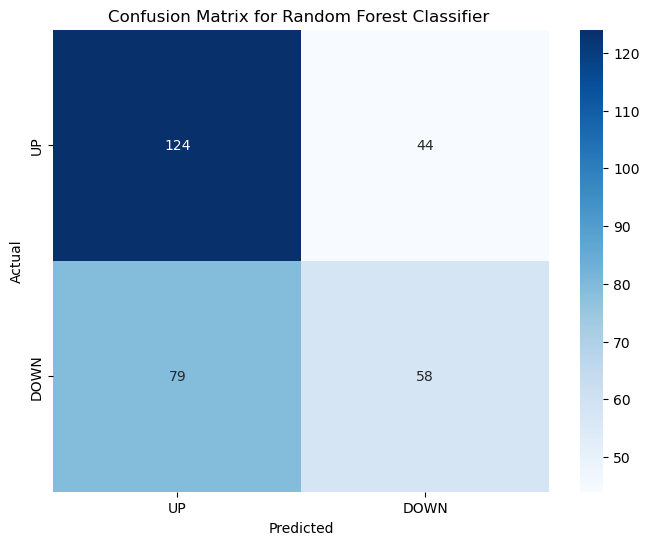

In [47]:
# Plot confusion matrix
plot_confusion_matrix('Confusion Matrix for Random Forest Classifier', y_test, test_preds)

#### Model: SVM (Support Vector Machine)

A Support Vector Classifier Model was used in a pipeline inline with a StandardScalar transformer. 

In [48]:
# SVM

svm_pipe = Pipeline([('transform', preprocessor), 
                     ('svc',SVC())])

start = time.time()
svm_pipe.fit(X_train, y_train)
train_secs = time.time()-start 

start = time.time()
train_preds = svm_pipe.predict(X_train)
predict_secs = time.time()-start 
test_preds = svm_pipe.predict(X_test)

modeling_cross_validation.loc[len(modeling_cross_validation)] = [
    "Support Vector Machine (SVM)", 
    train_secs, 
    predict_secs,
    accuracy_score(train_preds, y_train),
    accuracy_score (test_preds, y_test),
    metrics.recall_score(y_test, test_preds, pos_label='UP'),
    metrics.precision_score(y_test, test_preds, pos_label='UP'),
    metrics.f1_score(y_test, test_preds, pos_label='UP')
   ]


modeling_cross_validation

,Model Name,Train Time (sec),Train Predict Time (sec),Train Accuracy,Test Accuracy,Test Recall Score,Test Precision Score,Test F1 Score (Threat Det)
0,K Nearest Neighbors,0.017395,0.093432,0.714442,0.485246,0.517857,0.533742,0.525680
1,K Nearest Neighbors Tuning - k: 92,0.009342,0.027926,0.591904,0.544262,0.666667,0.574359,0.617080
2,Decision Tree - Depth: 17,0.024755,0.001525,1.000000,0.570492,0.619048,0.608187,0.613569
3,Decision Tree Tuning - Max Depth: 1,0.009562,0.001461,0.631291,0.606557,0.702381,0.627660,0.662921
4,Random Forest Classifier,0.168512,0.006324,0.724289,0.596721,0.738095,0.610837,0.668464
5,Support Vector Machine (SVM),0.026649,0.031702,0.722101,0.606557,0.720238,0.623711,0.668508


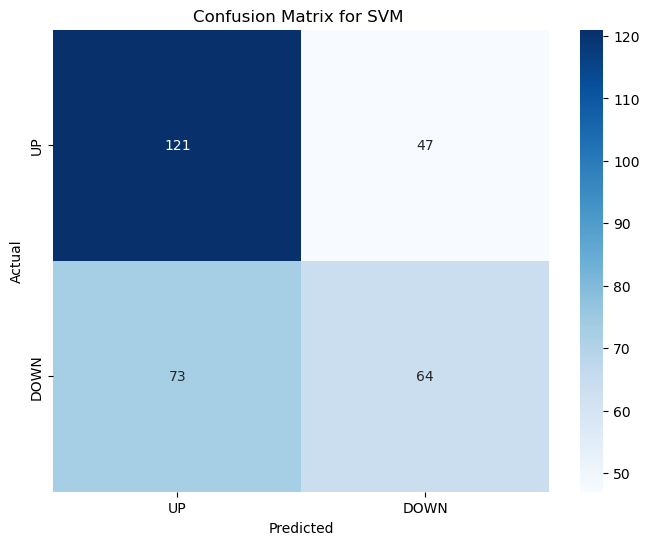

In [49]:
# Plot confusion matrix
plot_confusion_matrix('Confusion Matrix for SVM', y_test, test_preds)

### 4. Assess Model

### Model Assessment

With the Ideal Scenario Confusion Matrix in mind, model performance will be compared using confusion matricies. In these graphs, UP = predicted stock price increase and DOWN = predicted price decrease. Evaluation metrics were compared against a testing dataset separate from the training dataset. For the dataset of roughly 5 years of data, training and prediction times were all sub-second.  The models are listed in order from best performing to worst performing. 

In [50]:
modeling_cross_validation

,Model Name,Train Time (sec),Train Predict Time (sec),Train Accuracy,Test Accuracy,Test Recall Score,Test Precision Score,Test F1 Score (Threat Det)
0,K Nearest Neighbors,0.017395,0.093432,0.714442,0.485246,0.517857,0.533742,0.525680
1,K Nearest Neighbors Tuning - k: 92,0.009342,0.027926,0.591904,0.544262,0.666667,0.574359,0.617080
2,Decision Tree - Depth: 17,0.024755,0.001525,1.000000,0.570492,0.619048,0.608187,0.613569
3,Decision Tree Tuning - Max Depth: 1,0.009562,0.001461,0.631291,0.606557,0.702381,0.627660,0.662921
4,Random Forest Classifier,0.168512,0.006324,0.724289,0.596721,0.738095,0.610837,0.668464
5,Support Vector Machine (SVM),0.026649,0.031702,0.722101,0.606557,0.720238,0.623711,0.668508


**SVM (Support Vector Machine) Model**

Of the models evaluated, the SVC model performed the best at predicting price increases. It had the highest F1 score at 0.6685 and a precision score of 0.62. It was also the best model at identifying true positives and minimizing missed opportunities. The ratio of money making predictions (TP: 121) to money losing predictions (FP: 73) was 1.66 to 1.

**Random Forest Classifier Model**

The Random Forest Classifier is an ensemble model that uses multiple decision trees to improve predictive performance and reduce overfitting. It had a similar F1 performance at 0.6684 however was just a bit behind SVM in Precision at 0.61. 

**Decision Tree Model**

The tuned Decision Tree produced the highest Precision score of the models considered at 0.627. The result is the best ratio of money making trades to money losing trades at 1.69 to 1. However, it had only the third highest F1 score at 0.663 meaning that it had a higher rate of "missed opportunities." 

**K Nearest Neighbors Model**

After tuning, the KNN model had a F1 score of 0.617, a precision score of 0.574, and test accuracy of 0.544. 

<br><br>
A basic report with the details of the primary findings suitable for investors interested in fine-tuning stock purchasing decisions can be found in the Executive Summary section of this notebook. 

## Evaluation

### Evaluate Results
See Executive Summary above. 

### Determine Next Steps
See Executive Summary above. 

## Deployment

### Outline of Project

* Jupyter Notebook:  <a href="StockMarketPredictions.ipynb">StockMarketPredictions.ipynb</a>
* Download Data:  <a href="data/data.zip">data.zip</a>
* Final Report:  <a href="Stock Market Predictions Final Project Report.docx">Stock Market Predictions Final Project Report.doc</a>